In [1]:
from abc import ABC, abstractmethod
from itertools import combinations, product
from typing import Optional, Tuple, Union

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import affine_transform
from scipy.spatial.transform import Rotation

from src.utils.ct import MetaImageRSPImage

/home/kortus/rl-track-reconstruction/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ct = MetaImageRSPImage("data/phantom/imageDump.mhd", transform_hu_to_rsp=False)
voxels = ct.get_world_voxels()
radiograph = voxels.mean(axis=-1).T
R = np.ma.masked_where(radiograph <= -1000, radiograph)
radiograph[radiograph <= -500] = -500

In [3]:
def plot_detector_boundaries(ax):
    r = [-1, 1]
    scale = np.array([135, 75, 50]) 
    offset = np.array([0, 0, 50]) 
    vertices = np.array(list(product(r,r,r))) * scale + offset

    for s, e in combinations(vertices, 2):
        if np.count_nonzero(s - e) == 1:
            ax.plot3D(*zip(s,e), color="r", linewidth=0.5, zorder=10)

In [4]:
def plot_radiograph(radiograph, ax):
    xx, yy = np.meshgrid(np.arange(0, radiograph.shape[1], 1), np.arange(0, radiograph.shape[0], 1))
    xx = (xx - radiograph.shape[1]//2)
    yy = (yy - radiograph.shape[0]//2)
    zz = np.zeros_like(xx)

    norm = mpl.colors.Normalize(vmin=radiograph.min(), vmax=radiograph.max())
    ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, facecolors=plt.cm.gray(norm(radiograph)), norm=norm, shade=False, rasterized=True)

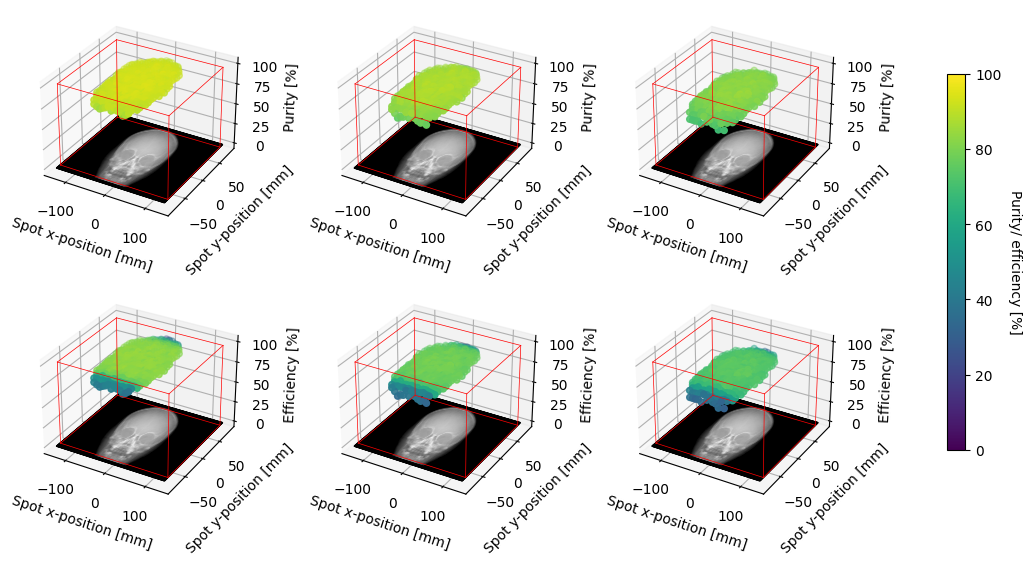

In [5]:
fig, ax = plt.subplots(2, 3, subplot_kw={"projection": "3d"}, figsize=(12, 6.5))

events = [50, 100, 150]

for i in range(3):
    dfs = [pd.read_csv(f"models/experiment_default_rl/results_head_phantom_spot_{events[i]}_{j}.txt") for j in range(5)]
    df = pd.concat(dfs)
    df_mean = df.groupby(["spotX", "spotY"], as_index=False).mean()
    cm1 = ax[0, i].scatter(df_mean.spotX, df_mean.spotY, df_mean.pur*100, c=df_mean.pur*100, vmin=0, vmax=100)
    cm2 = ax[1, i].scatter(df_mean.spotX, df_mean.spotY, df_mean.pur*100, c=df_mean.eff*100, vmin=0, vmax=100)
    plot_detector_boundaries(ax[0, i])
    plot_detector_boundaries(ax[1, i])
    
    ax[0,i].set_xlabel("Spot x-position [mm]")
    ax[0,i].set_ylabel("Spot y-position [mm]")
    ax[1,i].set_xlabel("Spot x-position [mm]")
    ax[1,i].set_ylabel("Spot y-position [mm]")
    ax[0,i].set_zlabel("Purity [%]")
    ax[1,i].set_zlabel("Efficiency [%]")
    plot_radiograph(radiograph, ax[0,i])
    plot_radiograph(radiograph, ax[1,i])
    
cbar = fig.colorbar(cm1, ax=ax[:,-1].ravel().tolist(), shrink=0.75, pad=0.2)
cbar.ax.set_ylabel('Purity/ efficiency [%]', rotation=270, labelpad=15)

bottom, top = 0.1, 0.9
left, right = 0.1, 0.78
fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, hspace=0.15, wspace=0.35)

plt.savefig("figures/performance_head_spotwise.png", bbox_inches="tight", dpi=300)
plt.savefig("figures/performance_head_spotwise.pdf", bbox_inches="tight")

0.19649121977777778 0.83917644565
0.17073690853333334 0.7157982623
0.1428146681666667 0.6129049163333333


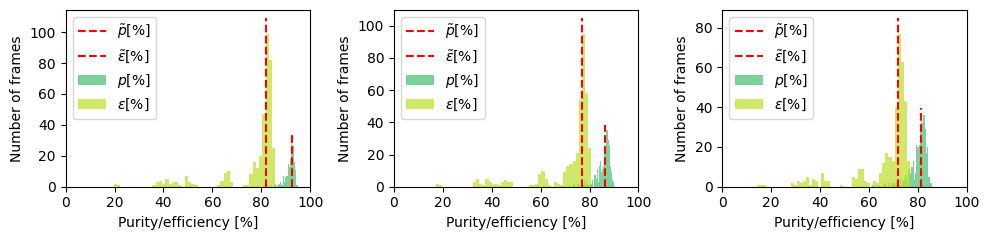

In [6]:
cmap = matplotlib.cm.get_cmap('viridis')

c0, c1 = cmap(0.7), cmap(0.9)
events = [50, 100, 150]

fig, ax = plt.subplots(1, 3, figsize=(10, 2.5))

for i in range(3):
    dfs = [pd.read_csv(f"models/experiment_default_rl/results_head_phantom_spot_{events[i]}_{j}.txt") for j in range(5)]
    df = pd.concat(dfs)
    df = df.groupby(["spotX", "spotY"], as_index=False).mean()
    hist_pur, _, _ =  ax[i].hist(df["pur"] * 100, bins = 50, alpha=0.7, color=c0)
    hist_eff, _, _ =  ax[i].hist(df["eff"] * 100,  bins = 50, alpha=0.7, color=c1)
    print(df["eff"].min(), df["pur"].min())
    ax[i].vlines(df["eff"].median() * 100, 0, hist_eff.max() + hist_eff.max()/10, color="red", linestyle="--")
    ax[i].vlines(df["pur"].median() * 100, 0, hist_pur.max() + hist_pur.max()/10, color="red", linestyle="--")
    ax[i].legend([r"$\tilde{p}$[%]", r"$\tilde{\epsilon}$[%]", r"$p$[%]", r"$\epsilon$[%]"])
    ax[i].set_xlim([0, 1.05])
    ax[i].set_xticks(np.arange(0, 110, 20))
    
    ax[i].set_xlabel("Purity/efficiency [%]")
    ax[i].set_ylabel("Number of frames")
    #ax[i].grid(True, linestyle=':', color='0')

plt.tight_layout()
plt.savefig("figures/performance_head_dist.png", dpi=300)
plt.savefig("figures/performance_head_dist.pdf")